# Hyperopt-Sklearn: Really Simple Hyperparameter Optimization
by Matthew Emery [@lstmemery](https://github.com/lstmemery/hyperopt-sklearn/tree/master/hpsklearn)

Thanks for having me
I can't really explain what I do in 20 seconds so let's just go

## What Is Hyperparameter Optimization?

- Every choice you make about a machine learning model you use is a hyperparameter
- This includes the choice of model itself as well as preprocessing steps
- Every dataset will have slightly different optimal hyperparameters

Example: The number of neighbours in nearest neighbours but also the distance

## What Makes Hyperparameter Optimization Tough?

- There are an infinite number of hyperparameters. 
- Many of those hyperparameters can take an infinite number of values.  
- Hyperparameters can interact with each other in unpredictable ways
- Evaluating hyperparameters means training a new model
- That's computationally expensive

## Classic Hyperparameter Optimization (Found in Sklearn)

<ul style="font-size:20px">
    <li>Grid search divides the hyperparameter space into even-spaced grids</li>
        <li>Random search just guesses totally randomly</li>
        <li>Random search is almost always a better idea then grid search
</li>
<ul>
<img src="./img/grid_vs_random.png" alt="https://medium.com/rants-on-machine-learning/smarter-parameter-sweeps-or-why-grid-search-is-plain-stupid-c17d97a0e881" width = "50%" height="50%">


- Explanation: Many hyperparameters don't really matter much
- Random search gives you more opportunties to explore the hyperparameters that do matter

## What if you could build a model to predict what combination of hyperparameters works best?

This is known as Sequential Model-Based Optimization
1. Gaussian Processes (GPyOpt)
2. **Tree-based Parzen Windows (Hyperopt)**

- This is a talk about Hyperopt
- Gaussian processes tend to work well with continuous variables
- Hyperparameter optimization is still  a very open field

## What is Hyperopt?

- Bayesian: The algorithm will stop picking values correlated with bad validation scores (As opposed to random search)
- Tree-based: The algorithm can model discrete, conditional, categorical and continuous variables

Details: Hyperopt approximates the density of "good" results for a given value of the hyperparameter

## What is Hyperopt-Sklearn?

- A wrapper for Hyperopt compatible with the scikit-learn API
- Also includes reasonable prior distributions for many scikit-learn models (plug and play)
- Supports XGBoost
- Checkout my fork of it is here: https://github.com/lstmemery/hyperopt-sklearn
- My main contribution: Fixing cross-validation, adding repeated cross-validation

![https://www.semanticscholar.org/paper/Hyperopt-Sklearn%3A-Automatic-Hyperparameter-for-Komer-Bergstra/7b2ce6eb25ab840936ae6bf2cd49bc7f20785bc4](./img/tpe_structure.png)

This is a way of visualizing hyperopt-sklearn. It selects a preprocessor randomly, then selects the hyperparameters for the preprocessor. This comes image comes from hyperopt-sklearn paper

In [15]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from random import randint
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import scikitplot as skplt
import warnings
from sklearn.externals import joblib
from hpsklearn import HyperoptEstimator, any_classifier
warnings.filterwarnings('ignore')
import pandas as pd
from collections import defaultdict


%matplotlib inline

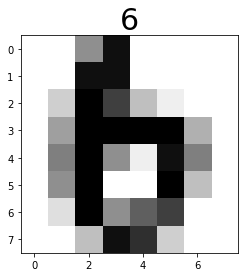

In [8]:
X, y = load_digits(return_X_y = True) # MNIST Dataset

(train_X, test_X, train_y, test_y) = train_test_split(X, y, 
                                     test_size = 0.2,
                                     random_state = 0) # Split the Data 
random_image = randint(0, len(train_X))
plt.title(train_y[random_image], fontsize=30)
plt.imshow(train_X[random_image].reshape(8, 8), cmap=plt.cm.gray_r)

- This is interactive in the notebook version
- I've loaded all the all the libraries ahead of time

0.944


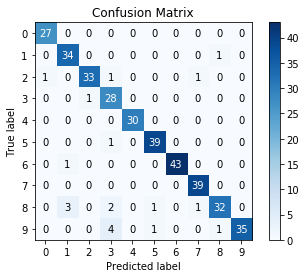

In [11]:
model = RandomForestClassifier(random_state = 0) # Basic Random Forest
model.fit(train_X, train_y)
print(accuracy_score(test_y, model.predict(test_X)).round(3))

skplt.metrics.plot_confusion_matrix(test_y, model.predict(test_X)) # Lookup Scikit-plot! 

- This is already really good. (About 1 in 20 wrong)
- I just love scikit-plot

In [37]:
from hpsklearn import HyperoptEstimator, any_classifier

hyperopt_model = HyperoptEstimator(classifier=any_classifier("mnist"),
                                   max_evals=100,
                                   seed=0)
hyperopt_model.fit(train_X,
              train_y,
              n_folds=5,
              cv_shuffle=True,
              random_state=0)

from sklearn.externals import joblib

joblib.dump(hyperopt_model, "hyperopt_model.pkl")

['hyperopt_model.pkl']

- This took about 30 minutes to run
- I normally run stuff like this overnight or in the cloud
- ALWAYS SAVE YOUR WORK
- You can also specify specific classifiers you want

0.989
{'learner': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='distance'), 'preprocs': (Normalizer(copy=True, norm='l2'),), 'ex_preprocs': ()}


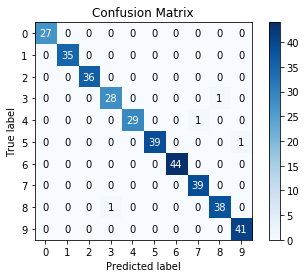

In [14]:
hyperopt_model = joblib.load("hyperopt_model.pkl")
hyperopt_predictions = hyperopt_model.predict(test_X)

print(accuracy_score(test_y, hyperopt_predictions).round(3))
print(hyperopt_model.best_model())
skplt.metrics.plot_confusion_matrix(test_y, hyperopt_predictions)

- We are now up to getting only 1 in 100 wrong
- If you are familar with MNIST, this model happens to be a really solid solution

In [ ]:
classifier_types = ["svc", "knn", "random\nforest", "extra\ntrees", "ada\nboost", "gradient\nboosting", "sgd"]

classifier_performance = defaultdict(list)
for index, classifier in enumerate(hyperopt_model.trials.trials):
    classifier_performance["index"].append(index)
    classifier_performance["loss"].append(1 - classifier["result"]["loss"]) # We want accuracy
    classifier_performance["classifier_type"].append(classifier_types[classifier['misc']['vals']["mnist"][0]])

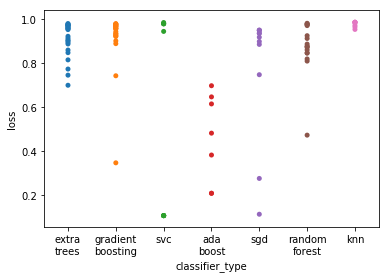

In [19]:
sns.stripplot(x="classifier_type", y="loss", data= pd.DataFrame(classifier_performance))

- This is a plot of performance for the different algorithms tried
- What you can see is some models clearly outperform others
- Why is gradient boosting fine but adapative not? Who knows

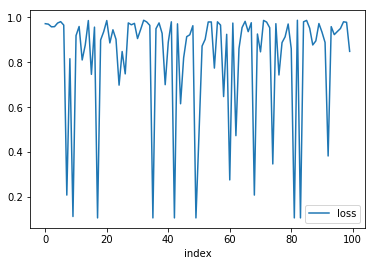

In [20]:
pd.DataFrame(classifier_performance).plot.line(x="index", y="loss")

- In this case the problem was rather easy so you don't notice a huge trend
- Over time those deep dips will start to disappear
- That wouldn't happen in random search

## Other Features

- Parallel Optimization through MongoDB
- Warm Starting (don't start from square one every time)

- These are both ways of dealing with larger datasets
- When in doubt, just buy a bigger instance

## What about Neural Networks?

- The Hyperopt library can be used to optimize any function
- Some kind soul built a keras-compatibility layer called [Hyperas](https://github.com/maxpumperla/hyperas)

- Hyperas has a similar syntax to Jinja or any other HTML templating library
- I haven't found anything for PyTorch

## Words to the Wise

- Hyperparameter optimization is computationally costly
- Your ideal hyperparameters will shift depending on feature engineering
- Create a few basic models first and see if validation accuracy improves
- **Don't do hyperparameter tuning until you are reasonably certain you won't be making big changes**

It's tempting to run this all the time. You shouldn't

## Optimization Bias

- In the example above I used 5-fold cross validation
- The more iterations of hyperparameter tuning you run, the more likely that you find a model that fits the validation data by chance (overfitting)
- If overfitting is an issue, increase your fold size or even perform cross-validation multiple times per iteration and average the results

If you are overfitting even with rather simple models, you likely have data leakage

## Other Hyperparameter Libraries

- Hyperband (subsampling, early-stopping random search)
- TPOT (Evolutionary pipeline building)
- Auto-sklearn (Ensemble building and meta-learning)

There's a new paper suggesting that you combine Hyperband and Hyperopt but no one has implemented it

## Questions?